## Multi class classification

In [61]:

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

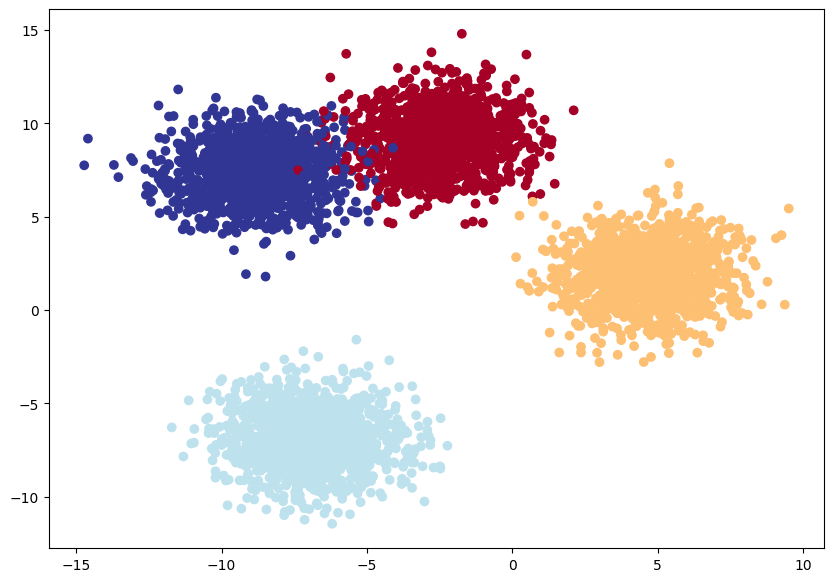

In [73]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples=5000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

# data to tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [75]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [76]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)


In [77]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test)

y_logits[:10]

tensor([[ 2.6446,  0.7065,  3.0386,  1.3806],
        [-0.2259, -1.7759, -0.4843,  0.9733],
        [-0.9871, -0.3682, -1.1204, -0.6909],
        [ 2.4781,  0.6081,  2.8408,  1.3226],
        [-1.3488, -0.7622, -1.5760, -0.6811],
        [ 0.1968, -1.5710,  0.0113,  1.1543],
        [-0.8046, -0.4158, -0.9260, -0.5103],
        [ 1.5960, -1.7763,  1.5243,  2.4190],
        [-1.7627, -0.6824, -2.0208, -1.0695],
        [ 1.6713, -1.2150,  1.6884,  2.0559]])

In [78]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[ 2.6446,  0.7065,  3.0386,  1.3806],
        [-0.2259, -1.7759, -0.4843,  0.9733],
        [-0.9871, -0.3682, -1.1204, -0.6909],
        [ 2.4781,  0.6081,  2.8408,  1.3226],
        [-1.3488, -0.7622, -1.5760, -0.6811]])
tensor([[0.3437, 0.0495, 0.5097, 0.0971],
        [0.1886, 0.0400, 0.1457, 0.6257],
        [0.1970, 0.3658, 0.1724, 0.2649],
        [0.3441, 0.0530, 0.4945, 0.1084],
        [0.1804, 0.3243, 0.1437, 0.3517]])


In [79]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

epochs = 10000

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(x_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train.long())
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                          y_pred=test_preds)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04274, Acc: 65.83% | Test Loss: 0.58041, Test Acc: 94.20%
Epoch: 10 | Loss: 0.14049, Acc: 98.92% | Test Loss: 0.13498, Test Acc: 98.70%
Epoch: 20 | Loss: 0.07717, Acc: 99.00% | Test Loss: 0.07941, Test Acc: 98.80%
Epoch: 30 | Loss: 0.05634, Acc: 99.02% | Test Loss: 0.05995, Test Acc: 98.80%
Epoch: 40 | Loss: 0.04643, Acc: 99.08% | Test Loss: 0.05043, Test Acc: 98.90%
Epoch: 50 | Loss: 0.04074, Acc: 99.08% | Test Loss: 0.04488, Test Acc: 98.90%
Epoch: 60 | Loss: 0.03710, Acc: 99.08% | Test Loss: 0.04129, Test Acc: 98.80%
Epoch: 70 | Loss: 0.03459, Acc: 99.08% | Test Loss: 0.03881, Test Acc: 98.80%
Epoch: 80 | Loss: 0.03276, Acc: 99.08% | Test Loss: 0.03700, Test Acc: 98.80%
Epoch: 90 | Loss: 0.03137, Acc: 99.08% | Test Loss: 0.03564, Test Acc: 98.80%
Epoch: 100 | Loss: 0.03029, Acc: 99.08% | Test Loss: 0.03458, Test Acc: 98.80%
Epoch: 110 | Loss: 0.02943, Acc: 99.08% | Test Loss: 0.03374, Test Acc: 98.80%
Epoch: 120 | Loss: 0.02873, Acc: 99.08% | Test Loss: 0.03306, T

In [80]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_blob_test)

y_logits[:10]

tensor([[-10.2969, -15.6087,  28.2461,  10.8260],
        [ 16.8892,   0.2485, -24.5085,   1.3637],
        [  4.8414,  23.8330, -19.9212, -18.5432],
        [ -9.1445, -14.2613,  25.5954,   9.8933],
        [  9.0240,  25.0693, -27.2989, -19.0516],
        [ 14.3837,  -3.5941, -18.1849,   4.1105],
        [  5.0276,  20.8980, -18.4141, -16.2118],
        [ 14.3242, -24.6004,  -5.1957,  20.6418],
        [  8.8644,  31.4612, -30.9699, -24.1016],
        [  8.9859, -20.3621,   0.6500,  16.7116]])

In [81]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.8237e-17, 8.9967e-20, 1.0000e+00, 2.7196e-08],
        [1.0000e+00, 5.9299e-08, 1.0501e-18, 1.8087e-07],
        [5.6505e-09, 1.0000e+00, 9.9499e-20, 3.9472e-19],
        [8.1780e-16, 4.9029e-18, 1.0000e+00, 1.5159e-07],
        [1.0755e-07, 1.0000e+00, 1.8063e-23, 6.8948e-20],
        [9.9997e-01, 1.5570e-08, 7.1712e-15, 3.4542e-05],
        [1.2811e-07, 1.0000e+00, 8.4521e-18, 7.6456e-17],
        [1.8010e-03, 2.2426e-20, 5.9994e-12, 9.9820e-01],
        [1.5357e-10, 1.0000e+00, 7.7001e-28, 7.4025e-25],
        [4.4114e-04, 7.9230e-17, 1.0576e-07, 9.9956e-01]])

In [82]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([2, 0, 1, 2, 1, 0, 1, 3, 1, 3])

In [83]:
y_blob_test

tensor([2, 0, 1, 2, 1, 0, 1, 3, 1, 3, 0, 2, 0, 3, 2, 3, 0, 1, 3, 2, 3, 3, 1, 3,
        2, 1, 3, 0, 1, 0, 3, 0, 3, 0, 1, 3, 3, 1, 0, 2, 2, 3, 2, 2, 1, 3, 2, 2,
        2, 0, 1, 0, 1, 1, 1, 3, 0, 0, 0, 2, 1, 3, 3, 1, 0, 1, 2, 1, 1, 0, 0, 3,
        3, 1, 2, 3, 0, 3, 3, 1, 0, 2, 1, 2, 3, 0, 1, 1, 2, 2, 1, 3, 2, 3, 0, 2,
        0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1, 2, 2, 0, 1, 3, 0, 3, 1, 2,
        2, 2, 2, 0, 2, 3, 2, 0, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 2, 1,
        2, 2, 2, 0, 2, 1, 3, 3, 1, 3, 1, 0, 1, 3, 3, 2, 0, 2, 2, 1, 3, 0, 3, 0,
        2, 1, 1, 1, 0, 3, 2, 1, 2, 1, 3, 1, 0, 3, 1, 3, 2, 3, 0, 2, 3, 3, 2, 0,
        2, 1, 3, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 1, 3, 0, 2, 1, 0, 1, 2, 2,
        3, 0, 2, 2, 2, 3, 3, 0, 3, 0, 2, 0, 0, 1, 3, 3, 1, 3, 1, 0, 3, 3, 2, 3,
        3, 2, 0, 1, 0, 0, 0, 2, 3, 1, 3, 1, 3, 2, 1, 1, 1, 0, 0, 3, 0, 3, 3, 3,
        0, 2, 1, 1, 2, 0, 2, 0, 1, 3, 2, 2, 1, 2, 3, 0, 3, 3, 1, 3, 3, 1, 2, 2,
        0, 1, 3, 1, 0, 1, 2, 3, 3, 2, 2,

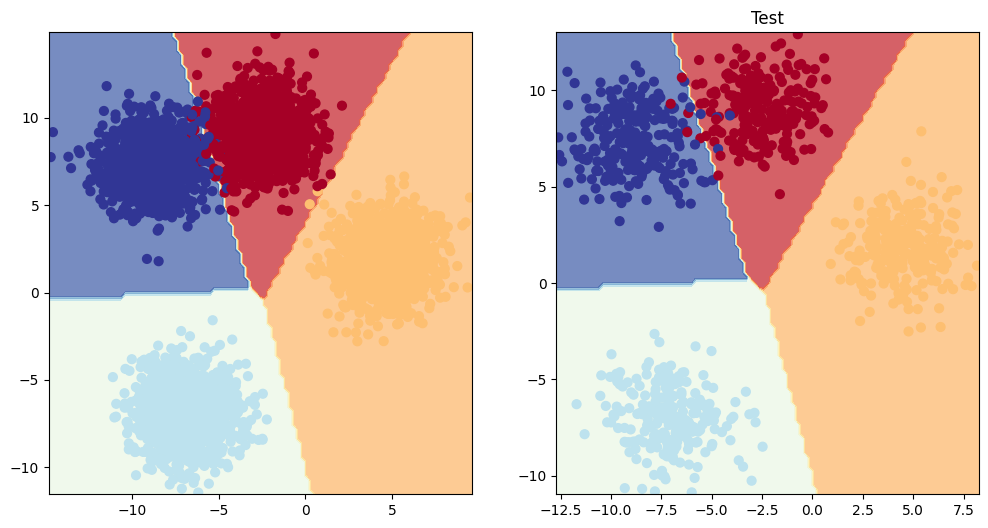

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)